# What do I want?

Previously in `classifier_overview.ipynb` I tested out some basic classifiers to get a smaller sample set, while still keeping completeness high.  I tested two basic classifiers: a RandomForest classifier and a Logistic Regression classifier.

For my training data, I started by getting objects and labels from COSMOS. For input features, I then matched those COSMOS galaxies to their nearest HSC counterpart. I then used HSC i-band magnitude, along with HSC g-r, r-i, i-z, z-y colors.

Choosing some arbitrary thresholds, I got similar results for the Random Forest and the Logistic Regression classifiers. In this notebook I'll look at the full ROC curves for both classifiers, in hopes of better understanding my results.

# Code

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

from scipy.special import expit

In [2]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [3]:
HSC_filename = os.path.join(dwarfz.data_dir_default, "HSC_COSMOS_median_forced.sqlite3")
HSC = dwarfz.datasets.HSC(HSC_filename)

In [4]:
matches_filename = os.path.join(dwarfz.data_dir_default, "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [5]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn magnitudes into colors

In [6]:
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

## Filter out bad data

In [7]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

## Get FRANKENZ photo-z's


In [8]:
df_frankenz = pd.read_sql_table("photo_z",
                                "sqlite:///{}".format(
                                    os.path.join(dwarfz.data_dir_default,
                                                 "HSC_matched_to_FRANKENZ.sqlite")),
                                index_col="object_id")

df_frankenz.head()

,FRANKENZ_ids,photoz_best,photoz_risk_best
object_id,,,
43158034708430853,43158034708462402,3.39,0.410430
43158034708430859,43158034708462728,2.68,0.186912
43158034708430861,43158034708462729,2.57,0.565077
43158034708430866,43158034708438547,1.59,0.466111
43158034708430870,43158034708438694,2.37,0.363387


In [9]:
combined = combined.join(df_frankenz[["photoz_best", "photoz_risk_best"]],
                         on="catalog_2_ids")

# Create classification labels

In [10]:
low_z    = (combined.photo_z  < .15)
low_mass = (combined.log_mass > 8) & (combined.log_mass < 9)

In [11]:
combined["low_z_low_mass"] = (low_z & low_mass)
combined.low_z_low_mass.mean()

0.0021850729760273151

# Build Classifiers

In [12]:
features = combined.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                           "icmodel_mag",
                           "photoz_best", 
                           "photoz_risk_best"
                          ]]

target = combined.loc[:,["low_z_low_mass"]]

In [13]:
target.mean()

low_z_low_mass    0.002185
dtype: float64

In [14]:
COSMOS_field_area = 2 # sq. degree
N_COSMOS_total = HSC.df.shape[0]
N_COSMOS_good = combined.shape[0]

true_dwarf_density = target.sum().values[0] / COSMOS_field_area 
print("true dwarf density: {:.2f} / sq. deg.".format(true_dwarf_density))

true dwarf density: 363.50 / sq. deg.


## Partition training and testing sets

In [15]:
testing_fraction = .1
test_set_indices = np.random.choice(target.index.values, 
                                    replace=False,
                                    size=int(testing_fraction*target.size)
                                   )

training_set_indices = np.array(list(set(target.index.values) - set(test_set_indices)))

features_train = features.loc[training_set_indices]
features_test  = features.loc[test_set_indices]

target_train   = target.loc[training_set_indices]
target_test    = target.loc[test_set_indices]

true_dwarf     =  target_test.values.flatten()
true_non_dwarf = ~target_test.values.flatten()

In [16]:
def get_classification_characteristics(target_prob, threshold_prob, verbose=False):

    target_prediction = (target_prob > threshold_prob)
    
    prediction_dwarf     =  target_prediction
    prediction_non_dwarf = ~target_prediction
    
    completeness = (true_dwarf & prediction_dwarf).sum() / true_dwarf.sum() 
    
    purity = (true_dwarf & prediction_dwarf).sum() / prediction_dwarf.sum() 
    
    sample_size_reduction = prediction_dwarf.size / prediction_dwarf.sum()
    
    true_positives  = np.sum(true_dwarf     & prediction_dwarf)
    false_positives = np.sum(true_non_dwarf & prediction_dwarf)
    
    true_negatives  = np.sum(true_non_dwarf & prediction_non_dwarf)
    false_negatives = np.sum(true_dwarf     & prediction_non_dwarf)
    
    true_positive_rate  = true_positives  / true_dwarf.sum()
    false_positive_rate = false_positives / true_non_dwarf.sum()
    
    objects_per_sq_deg = N_COSMOS_good / COSMOS_field_area / sample_size_reduction
    
    if verbose:
        print("completeness:          ", completeness)
        print("purity:                ", purity)
        print("sample_size_reduction: ", sample_size_reduction)
        print("true  positive rate:   ", true_positive_rate)
        print("false positive rate:   ", false_positive_rate)
        print("objects per sq deg:    ", objects_per_sq_deg)
        
    return {
        "completeness": completeness,
        "purity": purity,
        "sample_size_reduction": sample_size_reduction,
        "threshold_prob": threshold_prob,
        "true_positive_rate": true_positive_rate,
        "false_positive_rate": false_positive_rate,
        "objects_per_sq_deg" : objects_per_sq_deg,
           }

## Shared Plotting Parameters

In [17]:
color_RF = "g"
color_LR = "b"
color_MC = "r"

label_RF = "Random Forest"
label_LR = "Logistic Regression"
label_MC = "Magnitude Cut"

In [18]:
threshold_probs = expit(np.linspace(-9, 6))

## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

classifier_RF = RandomForestClassifier(n_estimators=1000)
classifier_RF = classifier_RF.fit(features_train, target_train.values.flatten())

target_prob_RF = classifier_RF.predict_proba(features_test)[:,1]
print("min prob: ", target_prob_RF.min())
print("max prob: ", target_prob_RF.max())


min prob:  0.0
max prob:  0.86


In [20]:
get_classification_characteristics(target_prob_RF, .01, verbose=True)

completeness:           0.907407407407
purity:                 0.0716374269006
sample_size_reduction:  48.6418128655
true  positive rate:    0.907407407407
false positive rate:    0.0191167173435
objects per sq deg:     3420.02055844


{'completeness': 0.90740740740740744,
 'false_positive_rate': 0.019116717343528915,
 'objects_per_sq_deg': 3420.0205584442911,
 'purity': 0.071637426900584791,
 'sample_size_reduction': 48.641812865497073,
 'threshold_prob': 0.01,
 'true_positive_rate': 0.90740740740740744}

In [21]:
results_RF = [get_classification_characteristics(target_prob_RF, threshold_prob)
              for threshold_prob in threshold_probs]

/Users/egentry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/egentry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


In [22]:
completenesses_RF         = [result["completeness"] for result in results_RF]
purities_RF               = [result["purity"] for result in results_RF]
sample_size_reductions_RF = [result["sample_size_reduction"] for result in results_RF]
objects_per_sq_deg_RF     = [result["objects_per_sq_deg"] for result in results_RF]
true_positive_rates_RF    = [result["true_positive_rate"] for result in results_RF]
false_positive_rates_RF   = [result["false_positive_rate"] for result in results_RF]

## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(class_weight=None)
classifier_LR = classifier_LR.fit(features_train, np.array(target_train.values.flatten(), dtype=int))

target_prob_LR = classifier_LR.predict_proba(features_test)[:,1] 
print("min prob: ", target_prob_LR.min())
print("max prob: ", target_prob_LR.max())

min prob:  6.79980850387e-12
max prob:  0.57406800972


In [24]:
get_classification_characteristics(target_prob_LR, .01, verbose=True)

completeness:           0.722222222222
purity:                 0.0348837209302
sample_size_reduction:  29.759391771
true  positive rate:    0.722222222222
false positive rate:    0.0324833669507
objects per sq deg:     5590.03360284


{'completeness': 0.72222222222222221,
 'false_positive_rate': 0.032483366950657795,
 'objects_per_sq_deg': 5590.0336028373058,
 'purity': 0.034883720930232558,
 'sample_size_reduction': 29.759391771019679,
 'threshold_prob': 0.01,
 'true_positive_rate': 0.72222222222222221}

In [25]:
results_LR = [get_classification_characteristics(target_prob_LR, threshold_prob)
              for threshold_prob in threshold_probs]

/Users/egentry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/egentry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


In [26]:
completenesses_LR         = [result["completeness"]          for result in results_LR]
purities_LR               = [result["purity"]                for result in results_LR]
sample_size_reductions_LR = [result["sample_size_reduction"] for result in results_LR]
objects_per_sq_deg_LR     = [result["objects_per_sq_deg"]    for result in results_LR]
true_positive_rates_LR    = [result["true_positive_rate"]    for result in results_LR]
false_positive_rates_LR   = [result["false_positive_rate"]   for result in results_LR]

## i-band magnitude cut (`MC`)

**WARNING** this probability is meaningless -- it's just for convenience!

In [27]:
from scipy import stats

In [28]:
percentiles = stats.rankdata(-combined.icmodel_mag) / combined.icmodel_mag.size

target_prob_MC = pd.Series(data=percentiles, index=combined.index)
target_prob_MC = target_prob_MC.loc[test_set_indices]

print("min prob: ", target_prob_MC.min())
print("max prob: ", target_prob_MC.max())

min prob:  1.20224097718e-05
max prob:  0.99998797759


In [29]:
get_classification_characteristics(target_prob_MC, .01, verbose=True)

completeness:           1.0
purity:                 0.00163954335681
sample_size_reduction:  1.0101712412
true  positive rate:    1.0
false positive rate:    0.989914802661
objects per sq deg:     164680.989931


{'completeness': 1.0,
 'false_positive_rate': 0.98991480266128784,
 'objects_per_sq_deg': 164680.98993117129,
 'purity': 0.0016395433568132136,
 'sample_size_reduction': 1.010171241195045,
 'threshold_prob': 0.01,
 'true_positive_rate': 1.0}

In [30]:
results_MC = [get_classification_characteristics(target_prob_MC, threshold_prob)
              for threshold_prob in threshold_probs]

In [31]:
completenesses_MC         = [result["completeness"]          for result in results_MC]
purities_MC               = [result["purity"]                for result in results_MC]
sample_size_reductions_MC = [result["sample_size_reduction"] for result in results_MC]
objects_per_sq_deg_MC     = [result["objects_per_sq_deg"]    for result in results_MC]
true_positive_rates_MC    = [result["true_positive_rate"]    for result in results_MC]
false_positive_rates_MC   = [result["false_positive_rate"]   for result in results_MC]

## Combined plots

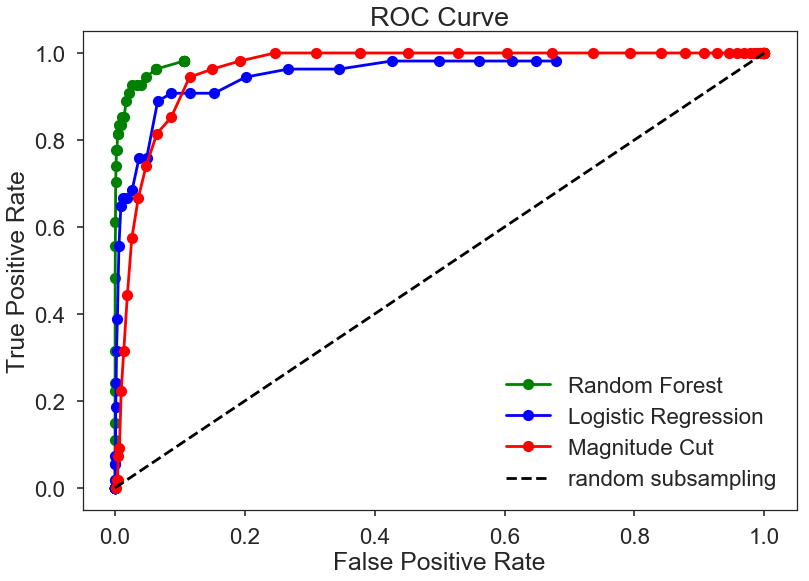

In [32]:
plt.plot(false_positive_rates_RF, true_positive_rates_RF, 
         marker="o", label=label_RF, color=color_RF)

plt.plot(false_positive_rates_LR, true_positive_rates_LR, 
         marker="o", label=label_LR, color=color_LR)

plt.plot(false_positive_rates_MC, true_positive_rates_MC, 
         marker="o", label=label_MC, color=color_MC)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 
         color="k", linestyle="dashed", label="random subsampling"
        )

plt.legend(loc="best")

plt.title("ROC Curve")

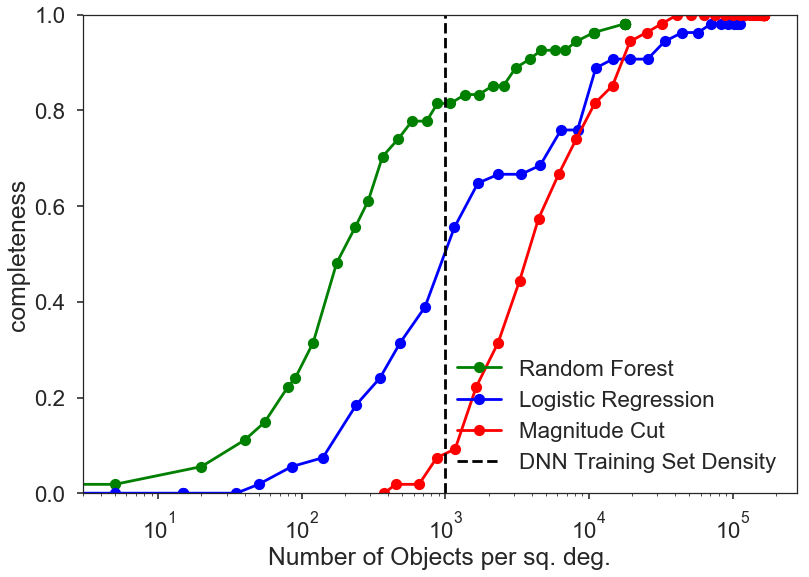

In [33]:
plt.plot(objects_per_sq_deg_RF, completenesses_RF, 
         marker="o", color=color_RF, label=label_RF,
        )

plt.plot(objects_per_sq_deg_LR, completenesses_LR, 
         marker="o", color=color_LR, label=label_LR,
        )

plt.plot(objects_per_sq_deg_MC, completenesses_MC, 
         marker="o", color=color_MC, label=label_MC,
        )

plt.axvline(1e3,
           color="black", linestyle="dashed", label="DNN Training Set Density")

plt.xlabel("Number of Objects per sq. deg.")
plt.ylabel("completeness")
plt.xscale("log")

plt.ylim(0,1)

plt.legend(loc="best")

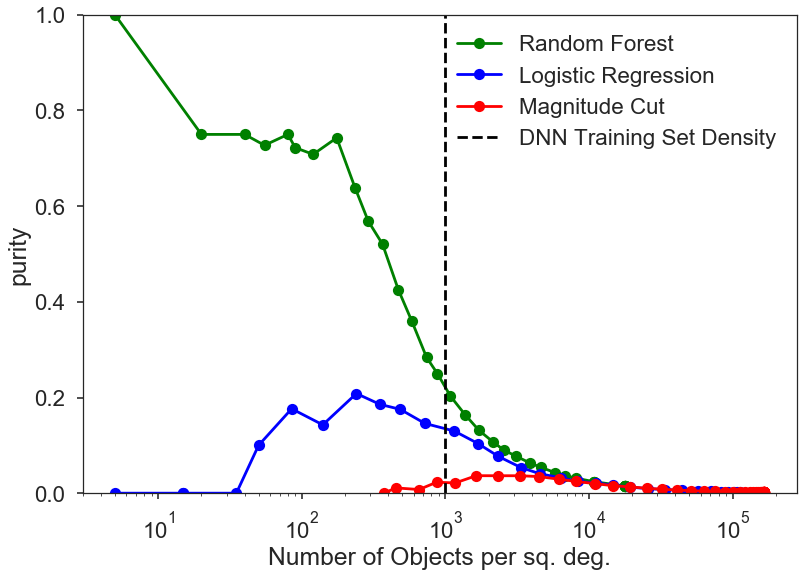

In [34]:
plt.plot(objects_per_sq_deg_RF, purities_RF, 
         marker="o", color=color_RF, label=label_RF)

plt.plot(objects_per_sq_deg_LR, purities_LR, 
         marker="o", color=color_LR, label=label_LR)

plt.plot(objects_per_sq_deg_MC, purities_MC, 
         marker="o", color=color_MC, label=label_MC)

plt.axvline(1e3,
           color="black", linestyle="dashed", label="DNN Training Set Density")

plt.xlabel("Number of Objects per sq. deg.")
plt.ylabel("purity")
plt.xscale("log")
plt.ylim(0,1)

plt.legend(loc="best")

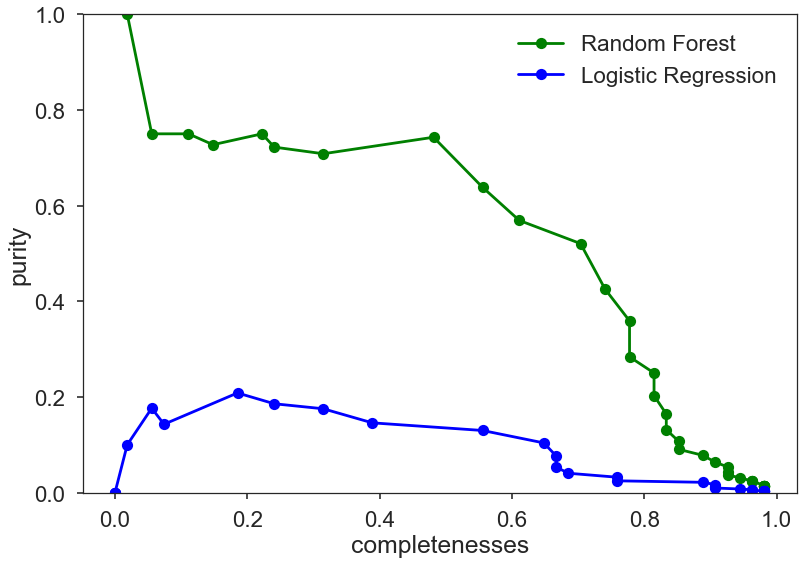

In [35]:
plt.plot(completenesses_RF, purities_RF, 
         marker="o", color=color_RF, label="Random Forest", 
        )
plt.plot(completenesses_LR, purities_LR, 
         marker="o", color=color_LR, label="Logistic Regression", 
        )

plt.xlabel("completenesses")
plt.ylabel("purity")
plt.ylim(0,1)


plt.legend(loc="best")

# Check Probability Calibration

## Predicted Probabilities

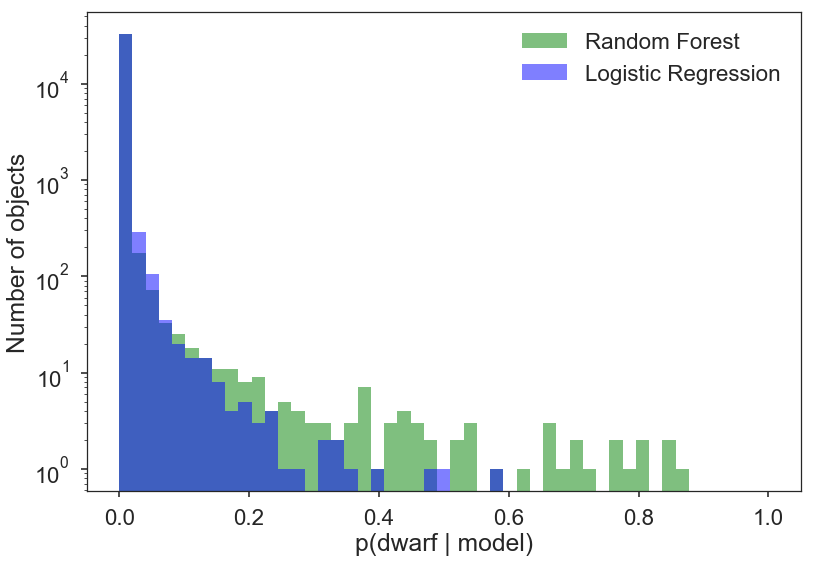

In [36]:
plt.hist(target_prob_RF, bins=np.linspace(0,1), alpha=.5, color=color_RF, label=label_RF)
plt.hist(target_prob_LR, bins=np.linspace(0,1), alpha=.5, color=color_LR, label=label_LR)

plt.yscale("log")
plt.xlabel("p(dwarf | model)")
plt.ylabel("Number of objects")

plt.legend(loc="best")

/Users/egentry/anaconda3/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/Users/egentry/anaconda3/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/Users/egentry/anaconda3/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in multiply
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/Users/egentry/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/egentry/anaconda3/lib/python3.6/site-packages/statsmodels/sand

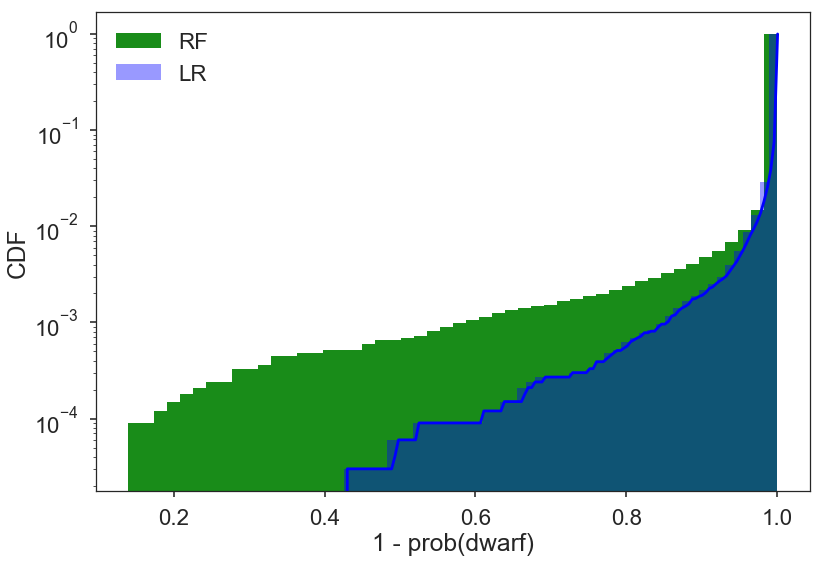

In [37]:
sns.distplot(1-target_prob_RF,
             hist_kws=dict(cumulative=True, alpha=0.9),
             kde_kws=dict(cumulative=True),
             label="RF",
             color=color_RF)

sns.distplot(1-target_prob_LR,
             hist_kws=dict(cumulative=True,),
             kde_kws=dict(cumulative=True),
             label="LR",
             color=color_LR)

plt.yscale("log")

plt.legend(loc="best")
plt.xlabel("1 - prob(dwarf)")
plt.ylabel("CDF")

## Empirical (Binned) Probabilities

In [38]:
theoretical_probs=np.linspace(0,1,num=11)

In [39]:
empirical_probs_RF = np.empty(theoretical_probs.size-1)
empirical_probs_LR = np.empty_like(empirical_probs_RF)

In [40]:
for i in range(theoretical_probs.size-1):
    prob_lim_low  = theoretical_probs[i]
    prob_lim_high = theoretical_probs[i+1]
    
    mask_RF = (target_prob_RF >= prob_lim_low) & (target_prob_RF < prob_lim_high)
    empirical_probs_RF[i] = target_test[mask_RF].mean()
    
    mask_LR = (target_prob_LR >= prob_lim_low) & (target_prob_LR < prob_lim_high)
    empirical_probs_LR[i] = target_test[mask_LR].mean()

/Users/egentry/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


(0, 1)

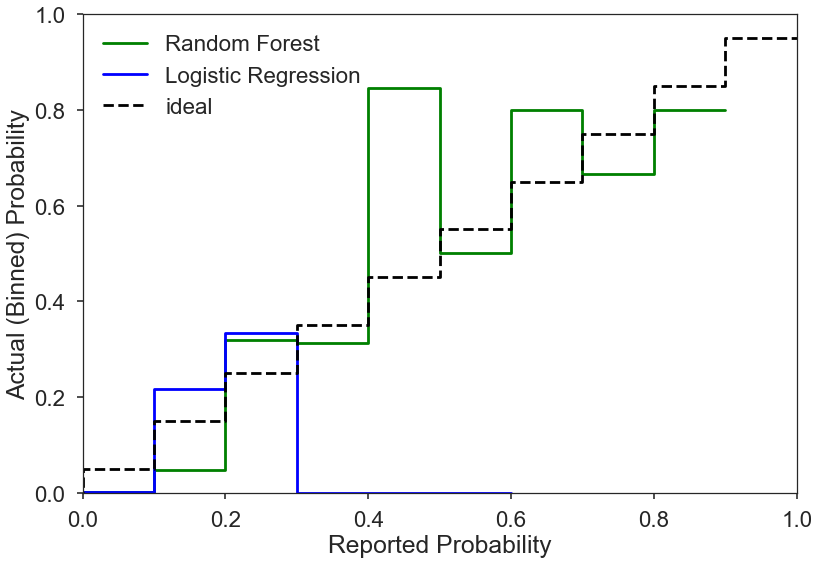

In [41]:
plt.step(theoretical_probs, [empirical_probs_RF[0], *empirical_probs_RF], 
         linestyle="steps", color=color_RF, label=label_RF)
plt.step(theoretical_probs, [empirical_probs_LR[0], *empirical_probs_LR], 
         linestyle="steps", color=color_LR, label=label_LR)

plt.plot(theoretical_probs, theoretical_probs-.05, 
         drawstyle="steps", color="black", label="ideal", linestyle="dashed")

plt.xlabel("Reported Probability")
plt.ylabel("Actual (Binned) Probability")

plt.legend(loc="best")

plt.xlim(0,1)
plt.ylim(0,1)
